Initial dataset shape: (1005167, 5)
Initial dataset preview:
   product_number         department_desc  discount date_of_order  orders
0               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-01       0
1               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-02       0
2               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-03       5
3               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-04       0
4               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-05       0
Dataset shape after removing duplicates: (1005167, 5)

Rows with Missing Dates (retained for now):
Empty DataFrame
Columns: [product_number, department_desc, discount, date_of_order, orders]
Index: []
Dataset shape after handling missing dates: (1005167, 5)

Handling Missing Values...
Remaining missing values after imputation:
product_number     0
department_desc    0
discount           0
date_of_order      0
orders             0
dtype: int64

Removing outliers for 'orders' and 'discount'..

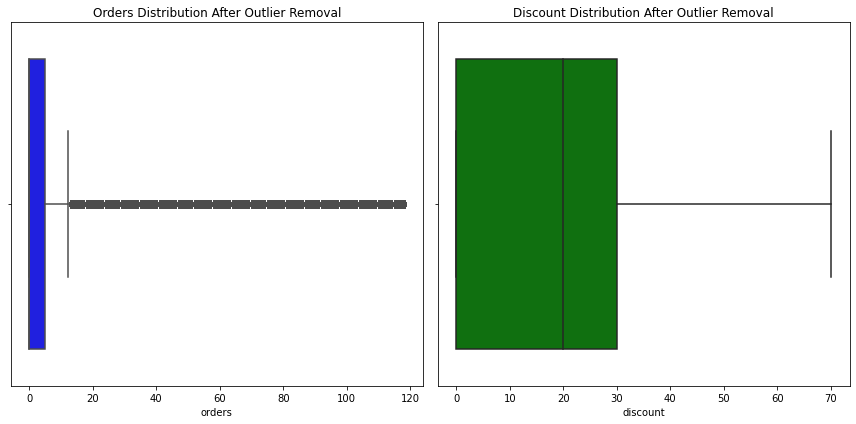

Upper Value Dataset Shape: (931006, 5)
Lower Value Dataset Shape: (931006, 5)
Upper discount data saved to: upper_discount_data.csv
Lower discount data saved to: lower_discount_data.csv


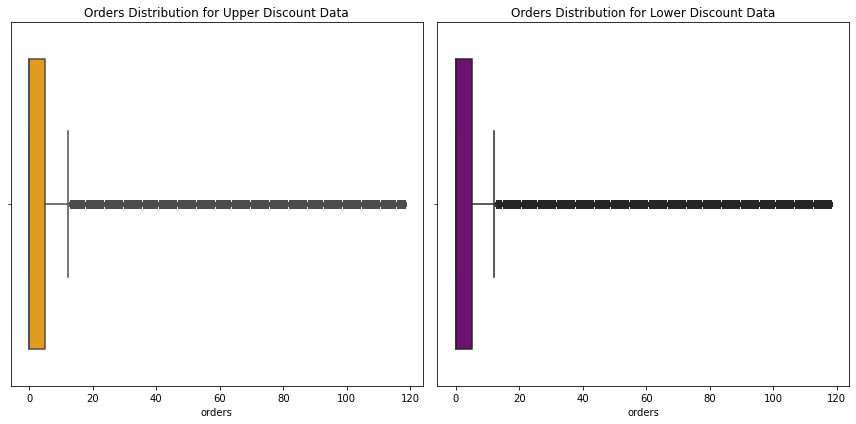

Data preprocessing completed successfully!


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '2022_orders_discount_data.csv'  # Replace with your file path
data_cleaned = pd.read_csv(file_path)
print(f"Initial dataset shape: {data_cleaned.shape}")
print(f"Initial dataset preview:\n{data_cleaned.head()}")

# 1. Remove Duplicates
data_cleaned.drop_duplicates(inplace=True)
print(f"Dataset shape after removing duplicates: {data_cleaned.shape}")

# 2. Handle Missing Dates
# Convert `date_of_order` to datetime and set format explicitly to 'YYYY-MM-DD'
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'], errors='coerce')

# Identify and print rows with missing dates
missing_date_rows = data_cleaned[data_cleaned['date_of_order'].isnull()]
print("\nRows with Missing Dates (retained for now):")
print(missing_date_rows)

# Replace missing dates with the earliest available date
data_cleaned['date_of_order'] = data_cleaned['date_of_order'].fillna(data_cleaned['date_of_order'].min())
print(f"Dataset shape after handling missing dates: {data_cleaned.shape}")

# 3. Handle Missing Values
print("\nHandling Missing Values...")

# Impute missing values for 'department_desc' with 'Unknown'
data_cleaned['department_desc'] = data_cleaned['department_desc'].fillna('Unknown')

# Impute missing values for 'discount' and 'orders' with their respective medians
data_cleaned['discount'] = data_cleaned['discount'].fillna(data_cleaned['discount'].median())
data_cleaned['orders'] = data_cleaned['orders'].fillna(data_cleaned['orders'].median())

# Verify remaining missing values
print(f"Remaining missing values after imputation:\n{data_cleaned.isnull().sum()}")

# 4. Define Outlier Removal Function
def remove_outliers_percentile(df, column, lower_percentile=1, upper_percentile=99):
    """
    Removes outliers from the specified column in the dataframe based on percentiles.
    Parameters:
        - df: pandas DataFrame
        - column: str, the column to check for outliers
        - lower_percentile: float, lower percentile threshold (e.g., 1 for 1st percentile)
        - upper_percentile: float, upper percentile threshold (e.g., 99 for 99th percentile)
    Returns:
        - Cleaned DataFrame with outliers removed.
    """
    lower_bound = np.percentile(df[column], lower_percentile)
    upper_bound = np.percentile(df[column], upper_percentile)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# 5. Remove Outliers
print("\nRemoving outliers for 'orders' and 'discount'...")
data_cleaned = remove_outliers_percentile(data_cleaned, column='orders', lower_percentile=1, upper_percentile=99)
data_cleaned = remove_outliers_percentile(data_cleaned, column='discount', lower_percentile=1, upper_percentile=99)
print(f"Dataset shape after removing outliers: {data_cleaned.shape}")

# Verify dataset statistics
print(f"\nDataset statistics after outlier removal:\n{data_cleaned[['orders', 'discount']].describe()}")

# Box plots after outlier removal
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=data_cleaned['orders'], color='blue')
plt.title('Orders Distribution After Outlier Removal')

plt.subplot(1, 2, 2)
sns.boxplot(x=data_cleaned['discount'], color='green')
plt.title('Discount Distribution After Outlier Removal')
plt.tight_layout()
plt.show()

# 6. Separate into Upper and Lower CSV Files
# Group by product and date, extract rows with max and min discounts
grouped_data = data_cleaned.groupby(['product_number', 'date_of_order'])
upper_value_data = grouped_data.apply(lambda x: x.loc[x['discount'].idxmax()]).reset_index(drop=True)
lower_value_data = grouped_data.apply(lambda x: x.loc[x['discount'].idxmin()]).reset_index(drop=True)

print(f"Upper Value Dataset Shape: {upper_value_data.shape}")
print(f"Lower Value Dataset Shape: {lower_value_data.shape}")

# Save the results to CSV files
upper_csv_path = 'upper_discount_data.csv'
lower_csv_path = 'lower_discount_data.csv'
upper_value_data.to_csv(upper_csv_path, index=False)
lower_value_data.to_csv(lower_csv_path, index=False)

print(f"Upper discount data saved to: {upper_csv_path}")
print(f"Lower discount data saved to: {lower_csv_path}")

# Visualize distributions of orders and discounts for upper and lower datasets
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=upper_value_data['orders'], color='orange')
plt.title('Orders Distribution for Upper Discount Data')

plt.subplot(1, 2, 2)
sns.boxplot(x=lower_value_data['orders'], color='purple')
plt.title('Orders Distribution for Lower Discount Data')

plt.tight_layout()
plt.show()

print("Data preprocessing completed successfully!")



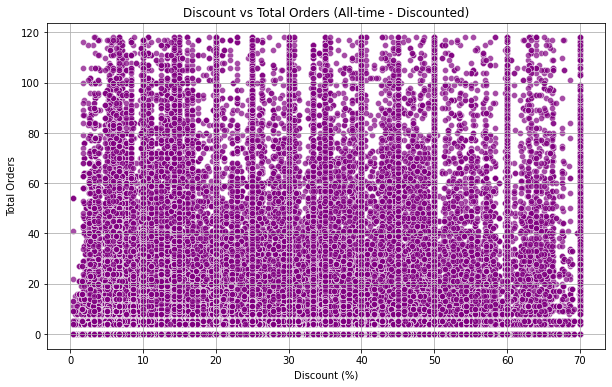

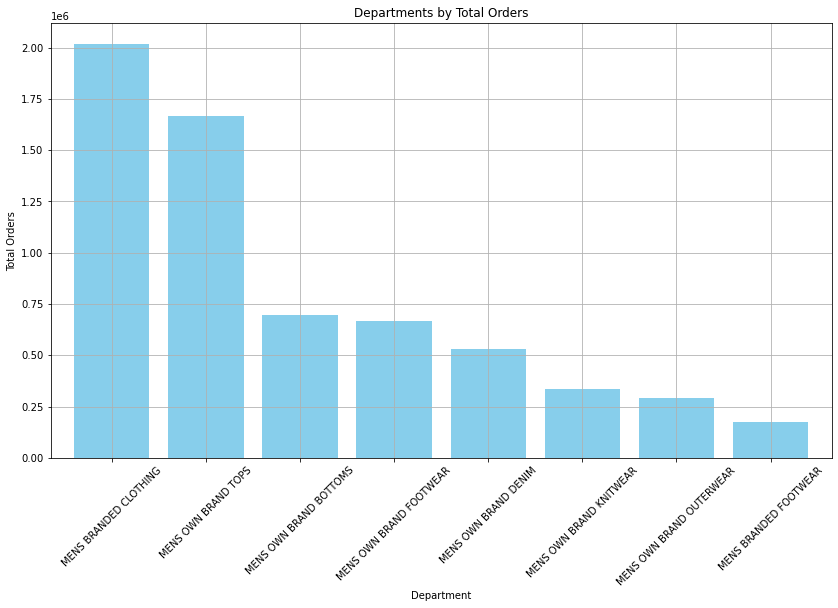

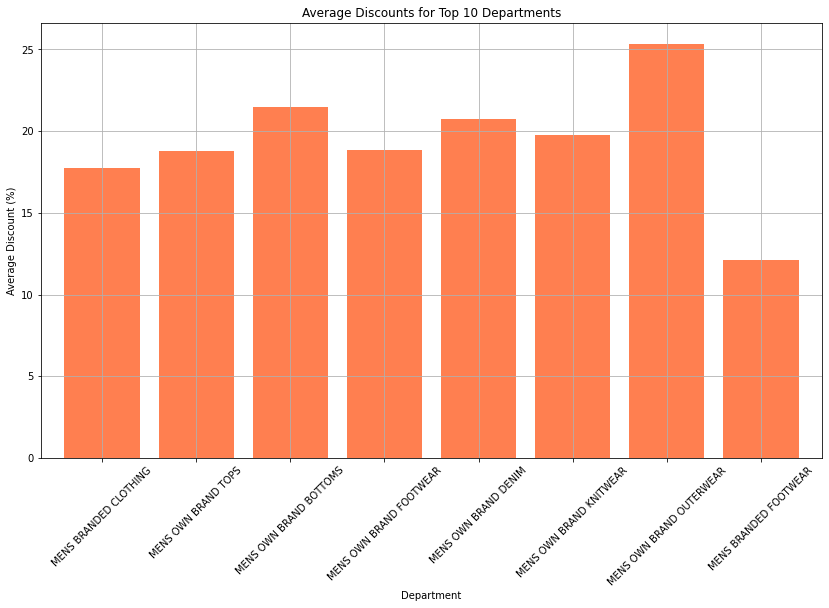

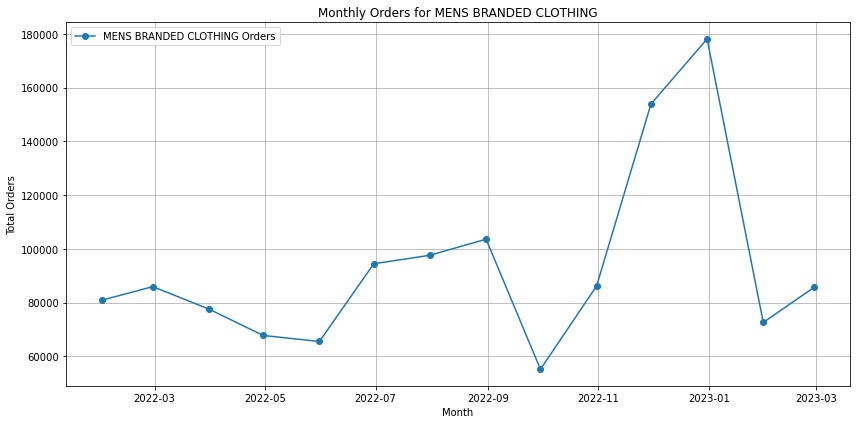

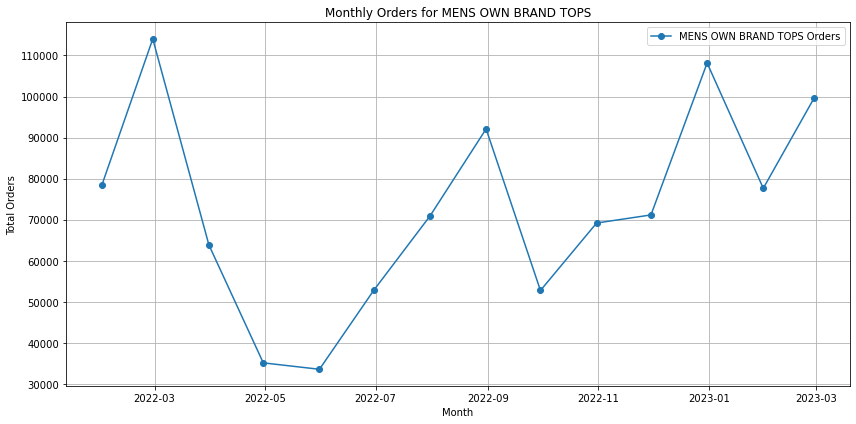

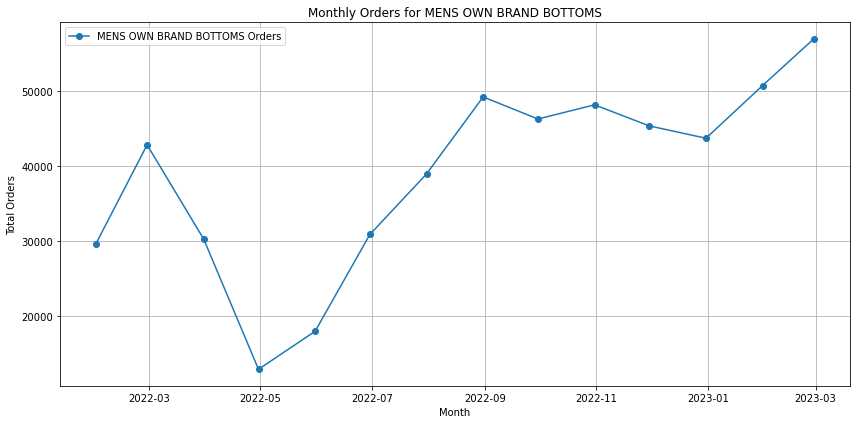

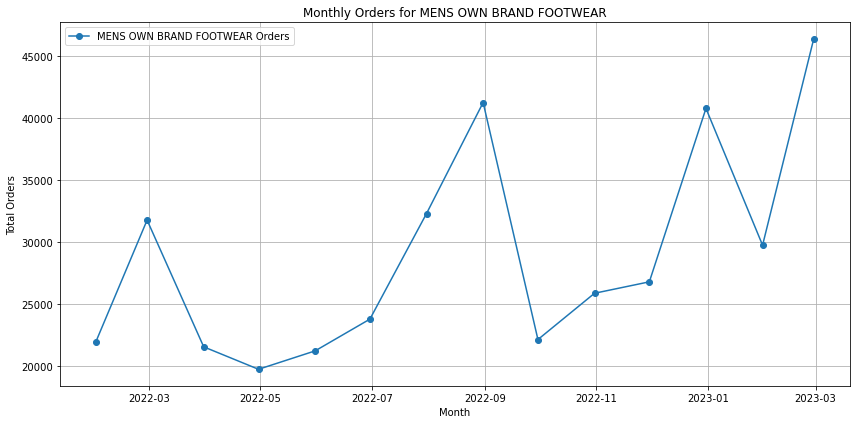

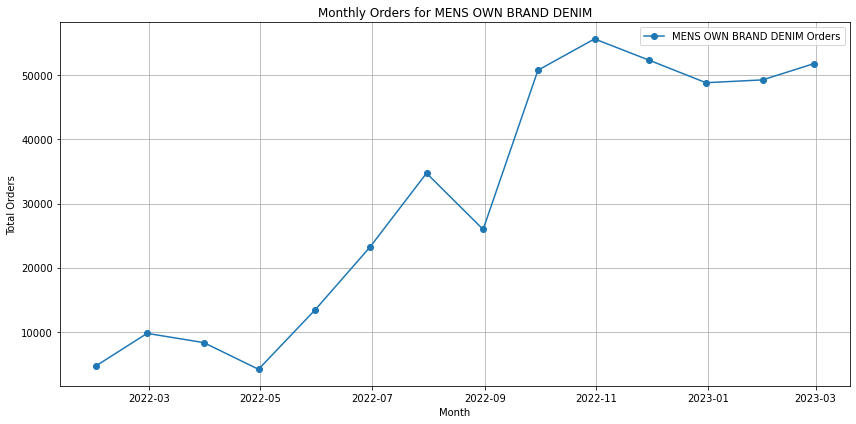

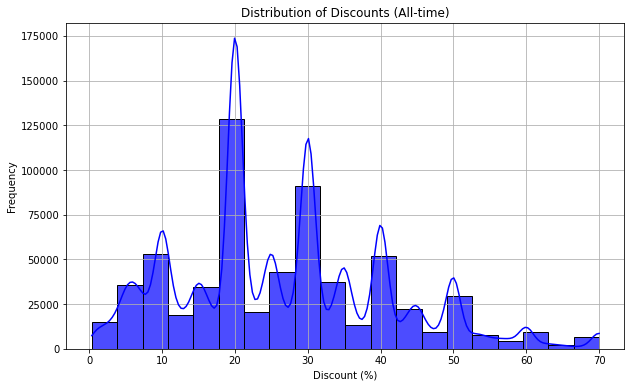

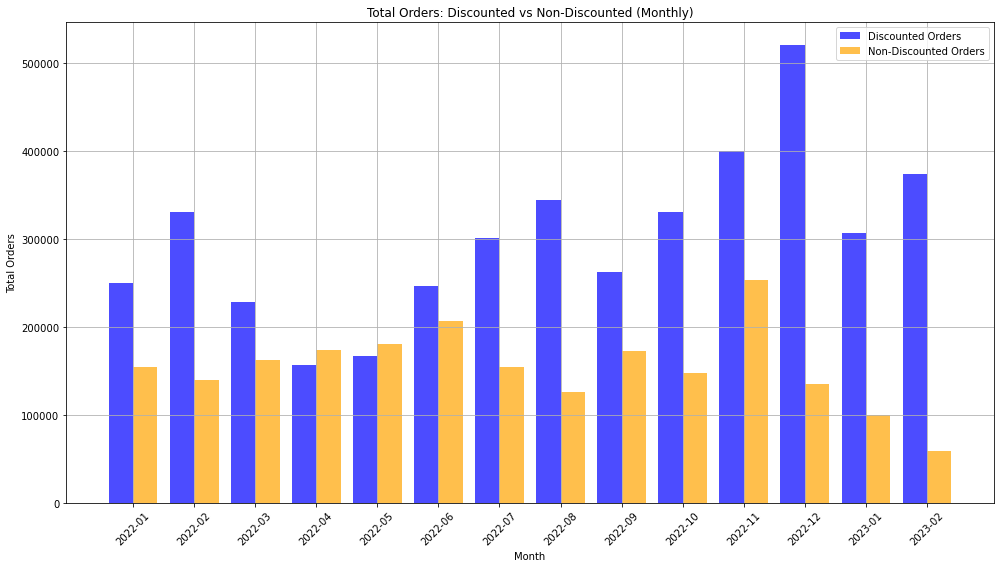

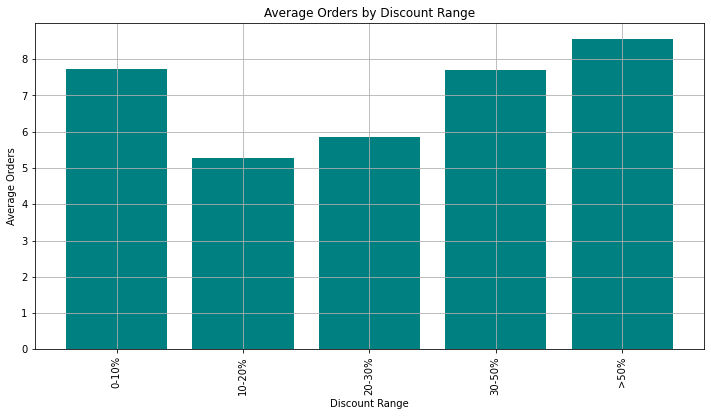

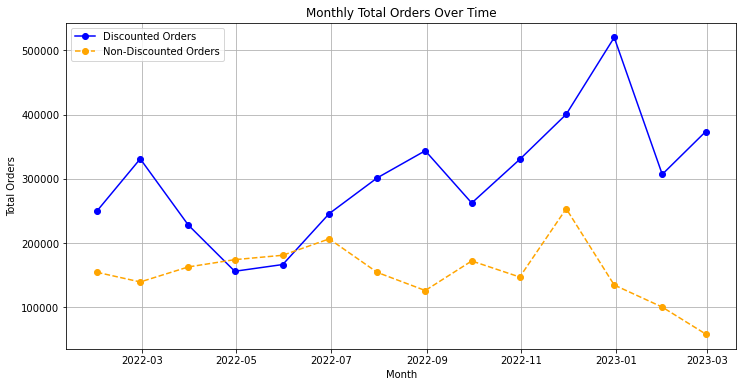

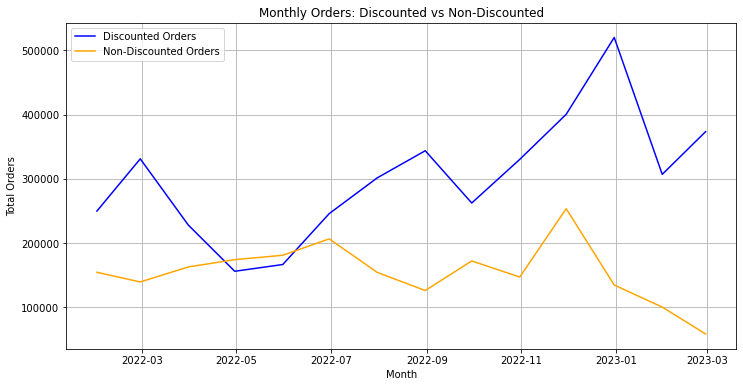

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load cleaned data
file_path = 'lower_discount_data.csv'
data_cleaned = pd.read_csv(file_path)

# Ensure the date column is datetime
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'])

# Validate discount segregation
if not all(data_cleaned['discount'] >= 0):
    raise ValueError("Discount column contains negative values, which are invalid.")

# Separate discounted and non-discounted data
discounted_data = data_cleaned[data_cleaned['discount'] > 0]
non_discounted_data = data_cleaned[data_cleaned['discount'] == 0]

# Aggregate data monthly for discounted and non-discounted separately
discounted_monthly = discounted_data.resample('M', on='date_of_order').agg({
    'orders': 'sum',
    'discount': 'mean'
}).reset_index()

non_discounted_monthly = non_discounted_data.resample('M', on='date_of_order').agg({
    'orders': 'sum'
}).reset_index()

# Merge the two datasets for analysis
monthly_data = pd.merge(
    discounted_monthly,
    non_discounted_monthly,
    on='date_of_order',
    how='outer',
    suffixes=('_discounted', '_non_discounted')
)

# Replace NaN with 0 to handle months without any orders for a specific category
monthly_data.fillna(0, inplace=True)

# Add discount range for analysis (for discounted data only)
bins = [0, 10, 20, 30, 50, 100]
labels = ['0-10%', '10-20%', '20-30%', '30-50%', '>50%']
if 'discount_discounted' in monthly_data.columns:
    monthly_data['discount_range'] = pd.cut(monthly_data['discount_discounted'], bins=bins, labels=labels)

### 1. Discount vs Orders Scatter Plot (All-time Aggregation)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount', y='orders', data=discounted_data, alpha=0.7, color="purple")
plt.title('Discount vs Total Orders (All-time - Discounted)')
plt.xlabel('Discount (%)')
plt.ylabel('Total Orders')
plt.grid(True)
plt.show()

### 2. Top Departments by Total Orders (Granular Analysis)
dept_aggregated = data_cleaned.groupby('department_desc').agg({
    'orders': 'sum',
    'discount': 'mean'
}).sort_values(by='orders', ascending=False)

# Top 10 Departments by Total Orders
plt.figure(figsize=(14, 8))
dept_aggregated['orders'].head(10).plot(kind='bar', color='skyblue', width=0.8)
plt.title('Departments by Total Orders')
plt.xlabel('Department')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Average Discounts for Top 10 Departments
plt.figure(figsize=(14, 8))
dept_aggregated['discount'].head(10).plot(kind='bar', color='coral', width=0.8)
plt.title('Average Discounts for Top 10 Departments')
plt.xlabel('Department')
plt.ylabel('Average Discount (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 3. Monthly Department-Level Analysis
top_departments = dept_aggregated.head(5).index

# For each department, plot monthly discounted orders
for department in top_departments:
    dept_data = discounted_data[discounted_data['department_desc'] == department]
    dept_monthly = dept_data.resample('M', on='date_of_order').agg({
        'orders': 'sum',
        'discount': 'mean'
    }).reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.plot(dept_monthly['date_of_order'], dept_monthly['orders'], marker='o', label=f'{department} Orders')
    plt.title(f'Monthly Orders for {department}')
    plt.xlabel('Month')
    plt.ylabel('Total Orders')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 4. Distribution of Discounts (Granular)
plt.figure(figsize=(10, 6))
sns.histplot(discounted_data['discount'], bins=20, kde=True, color='blue', alpha=0.7)
plt.title('Distribution of Discounts (All-time)')
plt.xlabel('Discount (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 5. Discounted vs Non-Discounted Sales (Monthly)
plt.figure(figsize=(14, 8))
x_positions = np.arange(len(monthly_data['date_of_order']))
plt.bar(
    x_positions - 0.2,
    monthly_data['orders_discounted'],
    width=0.4,
    label='Discounted Orders',
    color='blue',
    alpha=0.7
)
plt.bar(
    x_positions + 0.2,
    monthly_data['orders_non_discounted'],
    width=0.4,
    label='Non-Discounted Orders',
    color='orange',
    alpha=0.7
)
plt.xticks(x_positions, monthly_data['date_of_order'].dt.strftime('%Y-%m'), rotation=45)
plt.title('Total Orders: Discounted vs Non-Discounted (Monthly)')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 6. Average Orders by Discount Range
avg_orders_by_discount = discounted_data.groupby(pd.cut(discounted_data['discount'], bins=bins, labels=labels))['orders'].mean()

plt.figure(figsize=(12, 6))
avg_orders_by_discount.plot(kind='bar', color='teal', width=0.8)
plt.title('Average Orders by Discount Range')
plt.xlabel('Discount Range')
plt.ylabel('Average Orders')
plt.grid(True)
plt.show()

### 7. Monthly Total Orders Over Time
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['date_of_order'], monthly_data['orders_discounted'], marker='o', color='blue', label='Discounted Orders')
plt.plot(monthly_data['date_of_order'], monthly_data['orders_non_discounted'], marker='o', linestyle='--', color='orange', label='Non-Discounted Orders')
plt.title('Monthly Total Orders Over Time')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.show()

### 8. Monthly Orders: Discounted vs Non-Discounted (Granular Line Plot)
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_of_order', y='orders_discounted', data=monthly_data, label='Discounted Orders', color='blue')
sns.lineplot(x='date_of_order', y='orders_non_discounted', data=monthly_data, label='Non-Discounted Orders', color='orange')
plt.title('Monthly Orders: Discounted vs Non-Discounted')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.show()



Dataset loaded successfully.
Date column converted to datetime and month period added.
Data aggregated to monthly level.
Percentage changes calculated and clipped.
Elasticity calculated with error handling.
Product-level elasticity analysis saved.
Elastic products data saved to 'elastic_products_data.csv'.


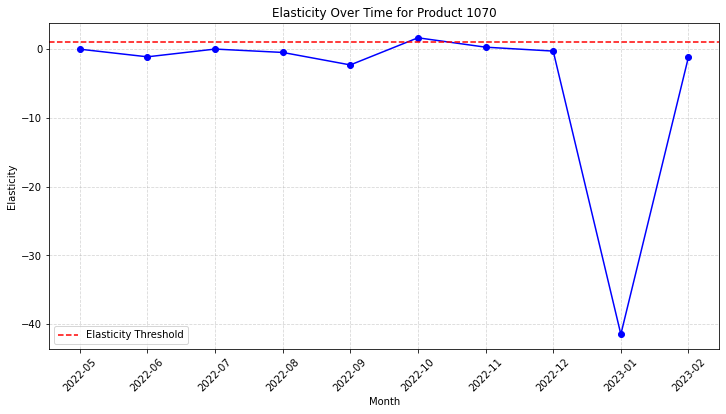

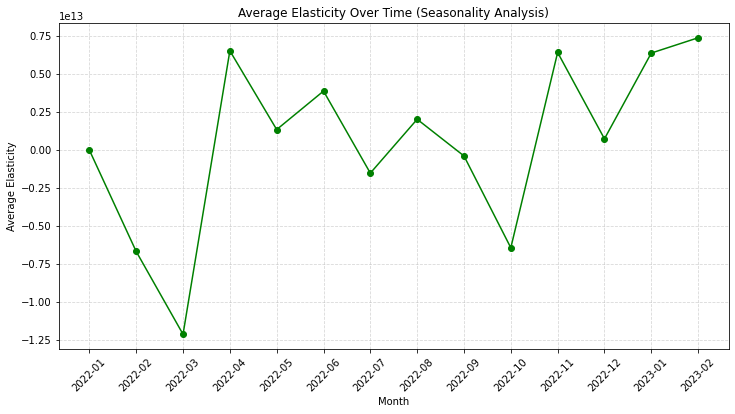

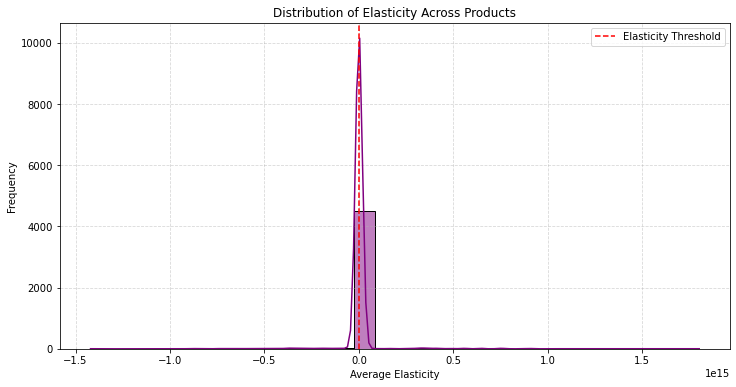

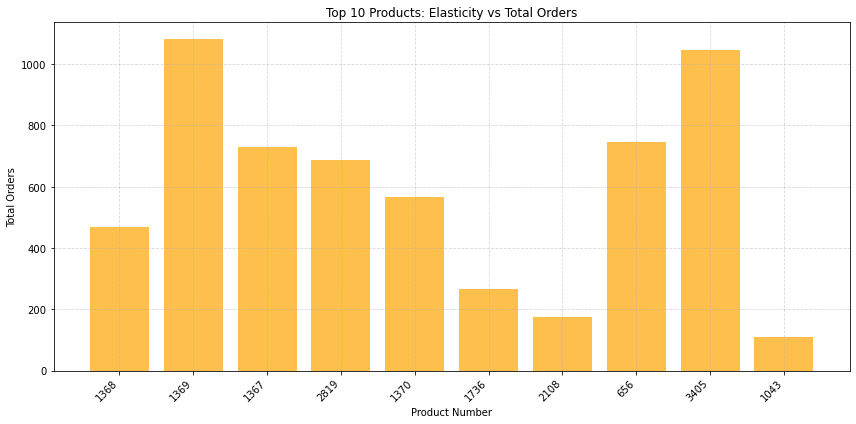

Elasticity over time has been successfully plotted for **Product 1090**.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize

# Step 1: Load the Dataset
file_path = 'lower_discount_data.csv'  # Replace with your actual file path
data_cleaned = pd.read_csv(file_path)
print("Dataset loaded successfully.")

# Step 2: Convert Date Column to Datetime and Add Month Period
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'])
data_cleaned['month'] = data_cleaned['date_of_order'].dt.to_period('M')  # Monthly periods
print("Date column converted to datetime and month period added.")

# Step 3: Aggregate Data at the Monthly Level
monthly_data = data_cleaned.groupby(['month', 'department_desc', 'product_number']).agg({
    'orders': 'sum',
    'discount': 'mean'
}).reset_index()
print("Data aggregated to monthly level.")

# Step 4: Handle Zero Discounts to Avoid Division Errors
monthly_data['discount'] = monthly_data['discount'].replace(0, 1e-6)

# Step 5: Calculate Percentage Changes for Orders and Discounts
monthly_data['pct_change_discount'] = (
    monthly_data.groupby('product_number')['discount'].pct_change().clip(lower=-1, upper=1)
)
monthly_data['pct_change_orders'] = (
    monthly_data.groupby('product_number')['orders'].pct_change().clip(lower=-1, upper=1)
)
print("Percentage changes calculated and clipped.")

# Step 6: Calculate Elasticity
monthly_data['elasticity'] = (
    monthly_data['pct_change_orders'] / monthly_data['pct_change_discount']
).replace([np.inf, -np.inf], np.nan).fillna(0)
print("Elasticity calculated with error handling.")

# Step 7: Winsorization to Limit Extreme Values (Less Aggressive)
monthly_data['elasticity'] = winsorize(monthly_data['elasticity'], limits=[0.0010, 0.0010])

# Save Elasticity at the Product Level
product_elasticity = monthly_data.groupby(['product_number', 'department_desc']).agg({
    'elasticity': 'mean',
    'orders': 'sum',
    'discount': 'mean'
}).reset_index()
product_elasticity.rename(columns={
    'elasticity': 'avg_elasticity',
    'orders': 'total_orders',
    'discount': 'avg_discount'
}, inplace=True)

product_elasticity.to_csv('product_elasticity_analysis.csv', index=False)
print("Product-level elasticity analysis saved.")

# Filter and Save Only Elastic Products (Elasticity > 1)
elastic_products = product_elasticity[product_elasticity['avg_elasticity'] > 1]
elastic_products.to_csv('elastic_products_data.csv', index=False)
print("Elastic products data saved to 'elastic_products_data.csv'.")

#  Elasticity Over Time for Product 1070**
product_1070 = monthly_data[monthly_data['product_number'] == 1070]

plt.figure(figsize=(12, 6))
plt.plot(product_1070['month'].astype(str), product_1070['elasticity'], marker='o', linestyle='-', color='blue')
plt.axhline(1, color='r', linestyle='dashed', label='Elasticity Threshold')
plt.xticks(rotation=45)
plt.title('Elasticity Over Time for Product 1070')
plt.xlabel('Month')
plt.ylabel('Elasticity')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Seasonality Analysis - Monthly Elasticity Trends**
monthly_avg_elasticity = monthly_data.groupby('month')['elasticity'].mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_elasticity.index.astype(str), monthly_avg_elasticity, marker='o', linestyle='-', color='green')
plt.xticks(rotation=45)
plt.title('Average Elasticity Over Time (Seasonality Analysis)')
plt.xlabel('Month')
plt.ylabel('Average Elasticity')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Elasticity Distribution
plt.figure(figsize=(12, 6))
sns.histplot(product_elasticity['avg_elasticity'], bins=30, kde=True, color='purple')
plt.axvline(1, color='r', linestyle='dashed', label='Elasticity Threshold')
plt.title('Distribution of Elasticity Across Products')
plt.xlabel('Average Elasticity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#  Top Products by Elasticity
top_10_products = product_elasticity.sort_values(by='avg_elasticity', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(
    top_10_products['product_number'].astype(str),
    top_10_products['total_orders'],
    color='orange', alpha=0.7
)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Products: Elasticity vs Total Orders')
plt.xlabel('Product Number')
plt.ylabel('Total Orders')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("Elasticity over time has been successfully plotted for **Product 1090**.")





In [15]:
import pandas as pd

# Step 1: Load the Original Dataset and Elastic Products Data
original_file_path = 'lower_discount_data.csv'  # Replace with your file path
elastic_products_file_path = 'elastic_products_data.csv'  # Replace with your file path

original_data = pd.read_csv(original_file_path)
elastic_products = pd.read_csv(elastic_products_file_path)

print("Datasets loaded successfully.")

# Step 2: Ensure 'product_number' is unique in the elastic products data
unique_elastic_products = elastic_products['product_number'].unique()
print(f"Number of unique elastic products: {len(unique_elastic_products)}")

# Step 3: Filter Rows in Original Dataset Based on Unique Elastic Products
filtered_data = original_data[original_data['product_number'].isin(unique_elastic_products)]

# Step 4: Save the Filtered Dataset
filtered_file_path = 'filtered_lower_discount_data.csv'
filtered_data.to_csv(filtered_file_path, index=False)

print(f"Filtered data saved to '{filtered_file_path}'.")
print(f"Filtered dataset shape: {filtered_data.shape}")


Datasets loaded successfully.
Number of unique elastic products: 971
Filtered data saved to 'filtered_lower_discount_data.csv'.
Filtered dataset shape: (218403, 5)


Filtered dataset loaded successfully.

--- Summary Statistics ---
              orders       discount
count  218403.000000  218403.000000
mean        6.008297      21.760211
std        13.387170      17.239960
min         0.000000       0.000000
25%         0.000000       5.410000
50%         0.000000      20.000000
75%         5.000000      34.220000
max       118.000000      70.000000

--- Kruskal-Wallis Test for Orders Across Seasons ---
Kruskal-Wallis Statistic: 53.8902, P-value: 0.0000
Significant differences in orders across seasons.

--- Multiple Linear Regression Analysis with Time-Specific Patterns ---
                            OLS Regression Results                            
Dep. Variable:                 orders   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     313.7
Date:                Fri, 31 Jan 2025   Prob (F-statistic):      

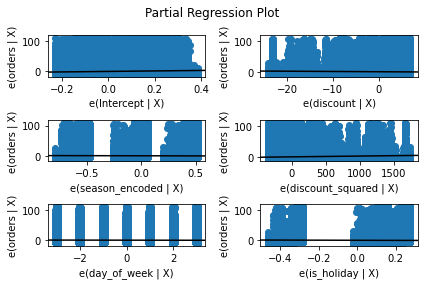


--- Bootstrap Analysis ---

Bootstrap Summary:
         Intercept     discount  season_encoded  discount_squared  \
count  1000.000000  1000.000000     1000.000000       1000.000000   
mean      8.205260    -0.085115       -0.734720          0.002493   
std       0.183700     0.004981        0.067167          0.000102   
min       7.602487    -0.099895       -1.030800          0.002111   
2.5%      7.845521    -0.094439       -0.873316          0.002288   
50%       8.200557    -0.085192       -0.736054          0.002497   
97.5%     8.578272    -0.075302       -0.603544          0.002680   
max       8.929971    -0.063014       -0.510661          0.002777   

       day_of_week   is_holiday  
count  1000.000000  1000.000000  
mean     -0.100731    -1.586854  
std       0.014133     0.126202  
min      -0.152681    -2.047992  
2.5%     -0.129155    -1.848345  
50%      -0.100233    -1.585714  
97.5%    -0.074246    -1.350387  
max      -0.055958    -1.190868  


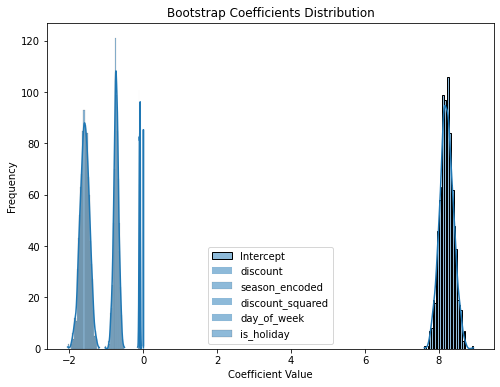

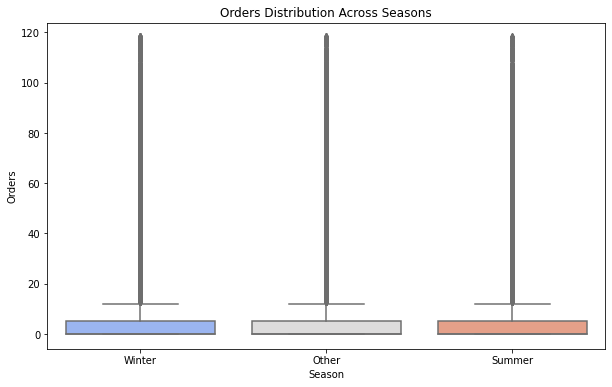

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from sklearn.utils import resample
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

# Load Filtered Dataset
file_path = 'filtered_lower_discount_data.csv'  # File containing only elastic products
data = pd.read_csv(file_path)
data['date_of_order'] = pd.to_datetime(data['date_of_order'])
print("Filtered dataset loaded successfully.")

# --- Summary Statistics ---
print("\n--- Summary Statistics ---")
summary_stats = data[['orders', 'discount']].describe()
print(summary_stats)

# --- Non-Parametric Test: Kruskal-Wallis Test ---
data['season'] = data['date_of_order'].dt.month.map(
    lambda x: 'Summer' if x in [6, 7, 8] else ('Winter' if x in [12, 1, 2] else 'Other')
)
groups = [data[data['season'] == season]['orders'] for season in ['Summer', 'Winter', 'Other']]
kruskal_stat, kruskal_p = kruskal(*groups)
print("\n--- Kruskal-Wallis Test for Orders Across Seasons ---")
print(f"Kruskal-Wallis Statistic: {kruskal_stat:.4f}, P-value: {kruskal_p:.4f}")
if kruskal_p < 0.05:
    print("Significant differences in orders across seasons.")
else:
    print("No significant differences in orders across seasons.")

# --- Multi-Regression Analysis ---
print("\n--- Multiple Linear Regression Analysis with Time-Specific Patterns ---")

# Encode the 'season' variable and add a squared discount term for non-linear effects
data['season_encoded'] = data['season'].map({'Summer': 1, 'Winter': 2, 'Other': 3})
data['discount_squared'] = data['discount'] ** 2  # Adding non-linear effects of discount

# Add day-of-week feature
data['day_of_week'] = data['date_of_order'].dt.dayofweek  # Monday = 0, Sunday = 6

# Add holiday indicator
# Assuming holidays include June to September or predefined general UK holidays
# Marking June to September as holidays (can be customized)
data['is_holiday'] = data['date_of_order'].dt.month.isin([6, 7, 8, ]).astype(int)

# Define the regression formula: Orders as a function of Discount, Season, Day of Week, Holidays, and Discount^2
formula = 'orders ~ discount + season_encoded + discount_squared + day_of_week + is_holiday'

# Fit the regression model
model = smf.ols(formula, data=data).fit()

# Print the summary of the model
print(model.summary())

# Plotting regression diagnostics
fig = sm.graphics.plot_partregress_grid(model)
plt.tight_layout()
plt.show()

# --- Bootstrap Analysis ---
print("\n--- Bootstrap Analysis ---")

# Bootstrap function to estimate confidence intervals for regression coefficients
def bootstrap_coefficients(data, formula, n_bootstrap=1000):
    coef_samples = []
    for i in range(n_bootstrap):
        sample = resample(data)  # Bootstrap resampling
        bootstrap_model = smf.ols(formula, data=sample).fit()
        coef_samples.append(bootstrap_model.params)
    return pd.DataFrame(coef_samples)

# Perform bootstrap analysis
bootstrap_results = bootstrap_coefficients(data, formula)
bootstrap_summary = bootstrap_results.describe(percentiles=[0.025, 0.5, 0.975])
print("\nBootstrap Summary:")
print(bootstrap_summary)

# Visualizing bootstrap confidence intervals
plt.figure(figsize=(8, 6))
for col in bootstrap_results.columns:
    sns.histplot(bootstrap_results[col], kde=True, label=f'{col}', bins=30)
plt.legend()
plt.title("Bootstrap Coefficients Distribution")
plt.xlabel("Coefficient Value")
plt.ylabel("Frequency")
plt.show()

# --- Visualization: Orders by Discount and Season ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='orders', data=data, palette='coolwarm')
plt.title("Orders Distribution Across Seasons")
plt.xlabel("Season")
plt.ylabel("Orders")
plt.show()

In [17]:
import pandas as pd

# Load the dataset
file_path = 'filtered_lower_discount_data.csv'
data = pd.read_csv(file_path)

# Ensure date_of_order is in datetime format
data['date_of_order'] = pd.to_datetime(data['date_of_order'])

# Find the latest date_of_order
latest_date = data['date_of_order'].max()
print(f"The latest date_of_order in the dataset is: {latest_date}")

# Filter the data for rows with the latest date_of_order
latest_date_data = data[data['date_of_order'] == latest_date]

# Print out information about the product(s) with the latest date
print("\nDetails for the product(s) with the latest date_of_order:")
print(latest_date_data)



The latest date_of_order in the dataset is: 2023-02-28 00:00:00

Details for the product(s) with the latest date_of_order:
        product_number         department_desc  discount date_of_order  orders
576                 12  MENS OWN BRAND BOTTOMS      40.0    2023-02-28       0
700                 18  MENS OWN BRAND BOTTOMS      40.0    2023-02-28      23
909                 20  MENS OWN BRAND BOTTOMS      10.0    2023-02-28      26
1042                25  MENS OWN BRAND BOTTOMS      10.0    2023-02-28       0
1218                30  MENS OWN BRAND BOTTOMS      20.0    2023-02-28       5
...                ...                     ...       ...           ...     ...
217626            4624   MENS BRANDED CLOTHING      10.0    2023-02-28       0
217734            4631   MENS BRANDED CLOTHING       0.0    2023-02-28       5
218024            4639   MENS BRANDED CLOTHING      10.0    2023-02-28       0
218199            4642   MENS BRANDED CLOTHING       0.0    2023-02-28       0
218402  


Linear Regression Model Performance:
R²: 0.7322
RMSE: 6.8933
MAE: 3.5521

Lasso Regression Model Performance:
R²: 0.7322
RMSE: 6.8933
MAE: 3.5509

ElasticNet Model Performance:
R²: 0.7322
RMSE: 6.8925
MAE: 3.5580

Random Forest Model Performance:
R²: 0.7400
RMSE: 6.7920
MAE: 3.4665

Gradient Boosting Model Performance:
R²: 0.7454
RMSE: 6.7211
MAE: 3.4448

Bayesian Ridge Model Performance:
R²: 0.7322
RMSE: 6.8934
MAE: 3.5519


/Users/atiyamahboob/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/atiyamahboob/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



SARIMA Metrics: RMSE = 602.5984, MAE = 421.5422, R² = 0.6290


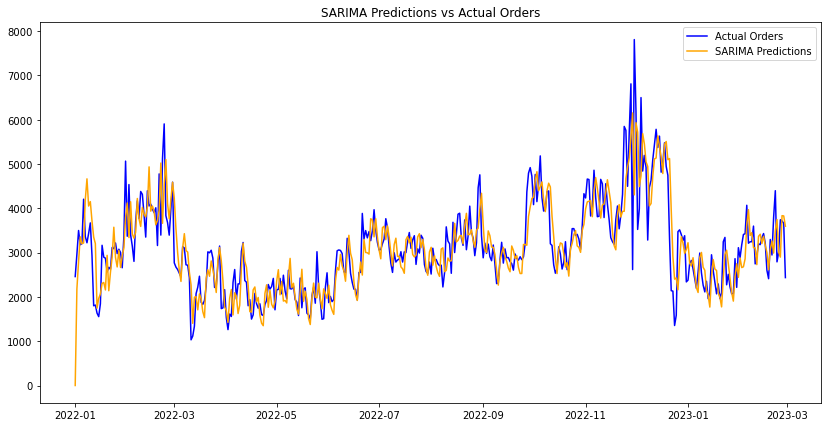

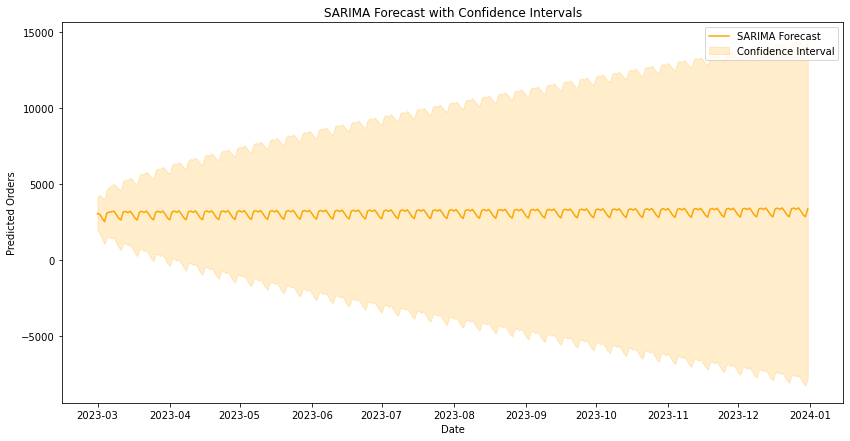

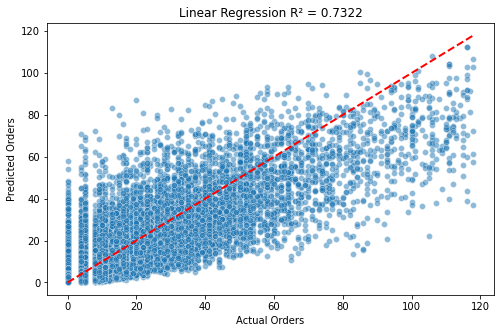

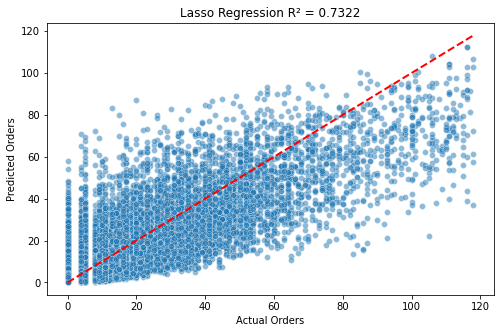

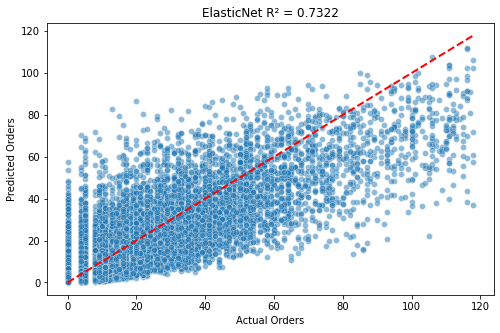

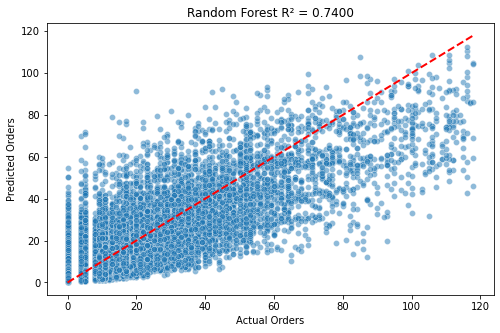

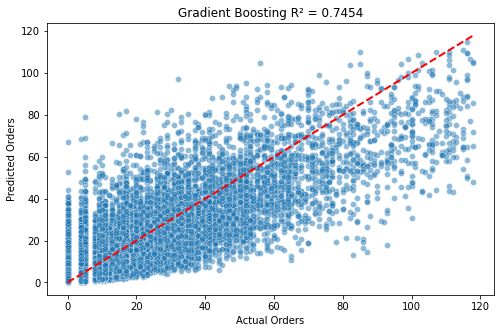

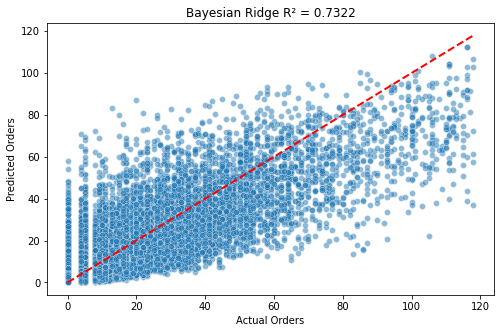

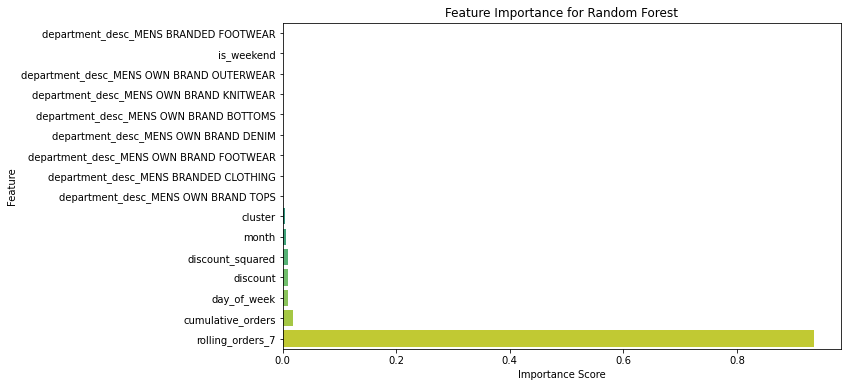

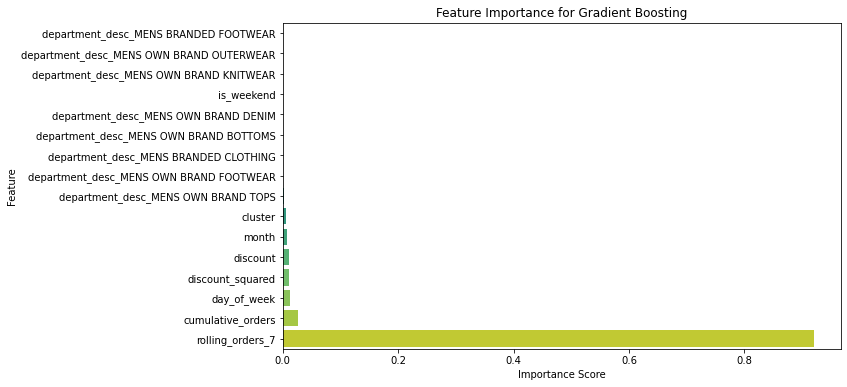


Model Performance Results:
               Model      RMSE       MAE        R²
0  Linear Regression  6.893338  3.552053  0.732162
1   Lasso Regression  6.893336  3.550911  0.732162
2         ElasticNet  6.892486  3.557997  0.732228
3      Random Forest  6.792036  3.466549  0.739976
4  Gradient Boosting  6.721064  3.444824  0.745382
5     Bayesian Ridge  6.893351  3.551854  0.732161


In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Load the dataset
file_path = 'filtered_lower_discount_data.csv'
data = pd.read_csv(file_path)
data['date_of_order'] = pd.to_datetime(data['date_of_order'])

# Feature Engineering
data['discount_squared'] = data['discount'] ** 2
data['day_of_week'] = data['date_of_order'].dt.dayofweek
data['month'] = data['date_of_order'].dt.month
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

# Add rolling and cumulative features
data['rolling_orders_7'] = data.groupby('product_number')['orders'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean())
data['cumulative_orders'] = data.groupby('product_number')['orders'].cumsum()

# Clustering-Based Features
product_features = data.groupby('product_number').agg({
    'orders': 'mean',
    'discount': 'mean',
    'day_of_week': 'mean',
    'is_weekend': 'mean'
}).reset_index()

kmeans = KMeans(n_clusters=5, random_state=42)
product_features['cluster'] = kmeans.fit_predict(product_features[['orders', 'discount', 'day_of_week', 'is_weekend']])
data = data.merge(product_features[['product_number', 'cluster']], on='product_number', how='left')

# Encode categorical features
encoder = OneHotEncoder()
encoded_categories = encoder.fit_transform(data[['department_desc']]).toarray()
encoded_columns = encoder.get_feature_names_out(['department_desc'])
encoded_df = pd.DataFrame(encoded_categories, columns=encoded_columns)
data = pd.concat([data.reset_index(drop=True), encoded_df], axis=1)

# Define Features and Target
X = data.drop(columns=['orders', 'date_of_order', 'department_desc', 'product_number'])
y = data['orders']

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.01, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42),
    'Bayesian Ridge': BayesianRidge()
}

# Create a directory for future predictions
output_dir = 'future_predictions'
os.makedirs(output_dir, exist_ok=True)

# Future Data for All of 2023 Predictions
future_dates = pd.date_range(start='2023-03-01', end='2023-12-31', freq='D')
unique_products = data[['product_number', 'department_desc', 'cluster']].drop_duplicates()

# Create future dataset for each product
future_data = pd.DataFrame()
for _, row in unique_products.iterrows():
    temp_data = pd.DataFrame({
        'product_number': row['product_number'],
        'department_desc': row['department_desc'],
        'cluster': row['cluster'],
        'date_of_order': future_dates
    })
    future_data = pd.concat([future_data, temp_data], axis=0)

# Add features for future predictions
future_data['discount'] = 0  # Assuming no discounts
future_data['discount_squared'] = 0 ** 2
future_data['day_of_week'] = future_data['date_of_order'].dt.dayofweek
future_data['month'] = future_data['date_of_order'].dt.month
future_data['is_weekend'] = future_data['day_of_week'].isin([5, 6]).astype(int)
rolling_mean = data.groupby('product_number')['orders'].mean()
future_data['rolling_orders_7'] = future_data['product_number'].map(rolling_mean)
future_data['cumulative_orders'] = future_data['product_number'].map(rolling_mean.cumsum())

# Encode future data
future_encoded = pd.DataFrame(
    encoder.transform(future_data[['department_desc']]).toarray(),
    columns=encoded_columns
)
future_data = pd.concat([future_data.reset_index(drop=True), future_encoded], axis=1)

# Align future features with training features
future_data = future_data[X.columns]

# Standardize features
future_data_scaled = scaler.transform(future_data)

# Store model results
results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred = np.maximum(y_pred, 0)  # Constrain predictions to non-negative

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append((name, rmse, mae, r2))

    print(f"\n{name} Model Performance:")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    # Future Predictions for this model
    future_predictions = model.predict(future_data_scaled)
    future_predictions = np.maximum(future_predictions, 0)
    future_predictions = np.round(future_predictions).astype(int)

    future_predictions_df = pd.DataFrame({
        'product_number': unique_products['product_number'].repeat(len(future_dates)).reset_index(drop=True),
        'department_desc': unique_products['department_desc'].repeat(len(future_dates)).reset_index(drop=True),
        'date_of_order': future_dates.tolist() * len(unique_products),
        'Predicted_Orders': future_predictions
    })

    future_predictions_df.to_csv(os.path.join(output_dir, f'future_predictions_{name.lower().replace(" ", "_")}.csv'), index=False)

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R²"])

# Load the dataset
file_path = 'filtered_lower_discount_data.csv'
data = pd.read_csv(file_path)
data['date_of_order'] = pd.to_datetime(data['date_of_order'])

# Aggregate orders by date for time series analysis
sarima_data = data.groupby('date_of_order')['orders'].sum()

# Fit SARIMA model
sarima_model = SARIMAX(sarima_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_results = sarima_model.fit(disp=False)

# Evaluate SARIMA
sarima_predictions = sarima_results.get_prediction(start=0, end=len(sarima_data)-1)
sarima_rmse = np.sqrt(mean_squared_error(sarima_data, sarima_predictions.predicted_mean))
sarima_mae = mean_absolute_error(sarima_data, sarima_predictions.predicted_mean)
sarima_r2 = r2_score(sarima_data, sarima_predictions.predicted_mean)
print(f"\nSARIMA Metrics: RMSE = {sarima_rmse:.4f}, MAE = {sarima_mae:.4f}, R² = {sarima_r2:.4f}")

# Create a directory for future predictions
output_dir = 'future_predictions'
os.makedirs(output_dir, exist_ok=True)

# Forecast for the rest of 2023
future_dates = pd.date_range(start='2023-03-01', end='2023-12-31', freq='D')
sarima_forecast = sarima_results.get_forecast(steps=len(future_dates))
sarima_forecast_df = pd.DataFrame({
    'date_of_order': future_dates,
    'Predicted_Orders': np.round(sarima_forecast.predicted_mean).astype(int),
    'Lower_CI': sarima_forecast.conf_int().iloc[:, 0],
    'Upper_CI': sarima_forecast.conf_int().iloc[:, 1]
})

sarima_forecast_df.to_csv(os.path.join(output_dir, 'sarima_predictions.csv'), index=False)

# SARIMA Predictions Plot
plt.figure(figsize=(14, 7))
plt.plot(sarima_data.index, sarima_data, label="Actual Orders", color="blue")
plt.plot(sarima_predictions.predicted_mean, label="SARIMA Predictions", color="orange")
plt.title("SARIMA Predictions vs Actual Orders")
plt.legend()
plt.show()

# SARIMA Forecast Plot with Confidence Intervals
plt.figure(figsize=(14, 7))
plt.plot(future_dates, sarima_forecast.predicted_mean, label="SARIMA Forecast", color="orange")
plt.fill_between(
    future_dates,
    sarima_forecast.conf_int().iloc[:, 0],
    sarima_forecast.conf_int().iloc[:, 1],
    color="orange",
    alpha=0.2,
    label="Confidence Interval",
)
plt.xlabel("Date")
plt.ylabel("Predicted Orders")
plt.title("SARIMA Forecast with Confidence Intervals")
plt.legend()
plt.show()

# ---------------- Predicted vs Actual Graphs ---------------- #
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_pred = np.maximum(y_pred, 0)  # Ensure non-negative predictions

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)  # Regression line
    plt.xlabel('Actual Orders')
    plt.ylabel('Predicted Orders')
    plt.title(f'{name} R² = {r2_score(y_test, y_pred):.4f}')
    plt.show()

# ---------------- Feature Importance Graphs ---------------- #
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
        importance.sort_values(by='Importance', ascending=True, inplace=True)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=importance['Importance'], y=importance['Feature'], palette="viridis")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.title(f"Feature Importance for {name}")
        plt.show()

# ---------------- Model Performance Table ---------------- #
print("\nModel Performance Results:")
print(results_df)  # Print the DataFrame to console
